In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'xsec_theta_result/' 
output_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_filesV4/'
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

plot_systematic = 0

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
#!jupyter nbconvert --to script numuCCana_xsec_weighted.ipynb

In [3]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# Cross section for single differnetial in Momentum (no sys)

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"xsec_theta_result.root","RECREATE");

#filename_overlay = 'NuCCana_Overlay_V18_V4.root'
filename_overlay = 'NuCCana_overlay_V26_weight.root'
#filename_overlay = 'NuCCana_overlay_v25_weighted_all.root'
filename_data = 'NuCCana_data_V25.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [5]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =    7.644e+18  # best with tor875
data_trigger = 1838700.0 #2220362.0 #1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	989745
Data: Number of Entries:	28005
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		7.644e+18
Ext:		0
Overlay:	1.24025430537e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0967862715198
Overlay:	0.00616325213863
Dirt:		0.0611423668132


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [6]:
if 1:
    filename_overlay = filename_overlay+'out4.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out4.root'
    filename_ext = filename_ext+'out4.root'
    filename_dirt = filename_dirt+'out4.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	989714
Data: Number of Entries:	28004
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40800



In [7]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [8]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [9]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')

num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [10]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root,outputdir_pdf)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [11]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [12]:
'''track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'
'''
track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-4)<0.9 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-4)<0.9 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.95)<0.9 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [13]:
from array import array
mom_bins = [ -1.00, -0.50, 0.00, 0.28, 0.47, 0.63, 0.765, 0.865, 0.935, 1.00 ]
binnum = len(mom_bins) - 1
h_xsec_mom = ROOT.TH1F('h_xsec_mom','h_xsec_mom',binnum,array('f',mom_bins))

In [14]:
def draw_adding():
    prelim = ROOT.TLatex(0.95,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/23.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/23.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/20.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

def draw_adding_ratio():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/15.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .91,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/15.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim_ratio():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/15.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [15]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [16]:
path_cv = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_filesV4/'
#path_cv = '/home/tmettler/Desktop/weighted/xsec_phasespacerestriction/'
f_cv = ROOT.TFile.Open(path_cv+"xsec_theta_wighted.root", 'read')

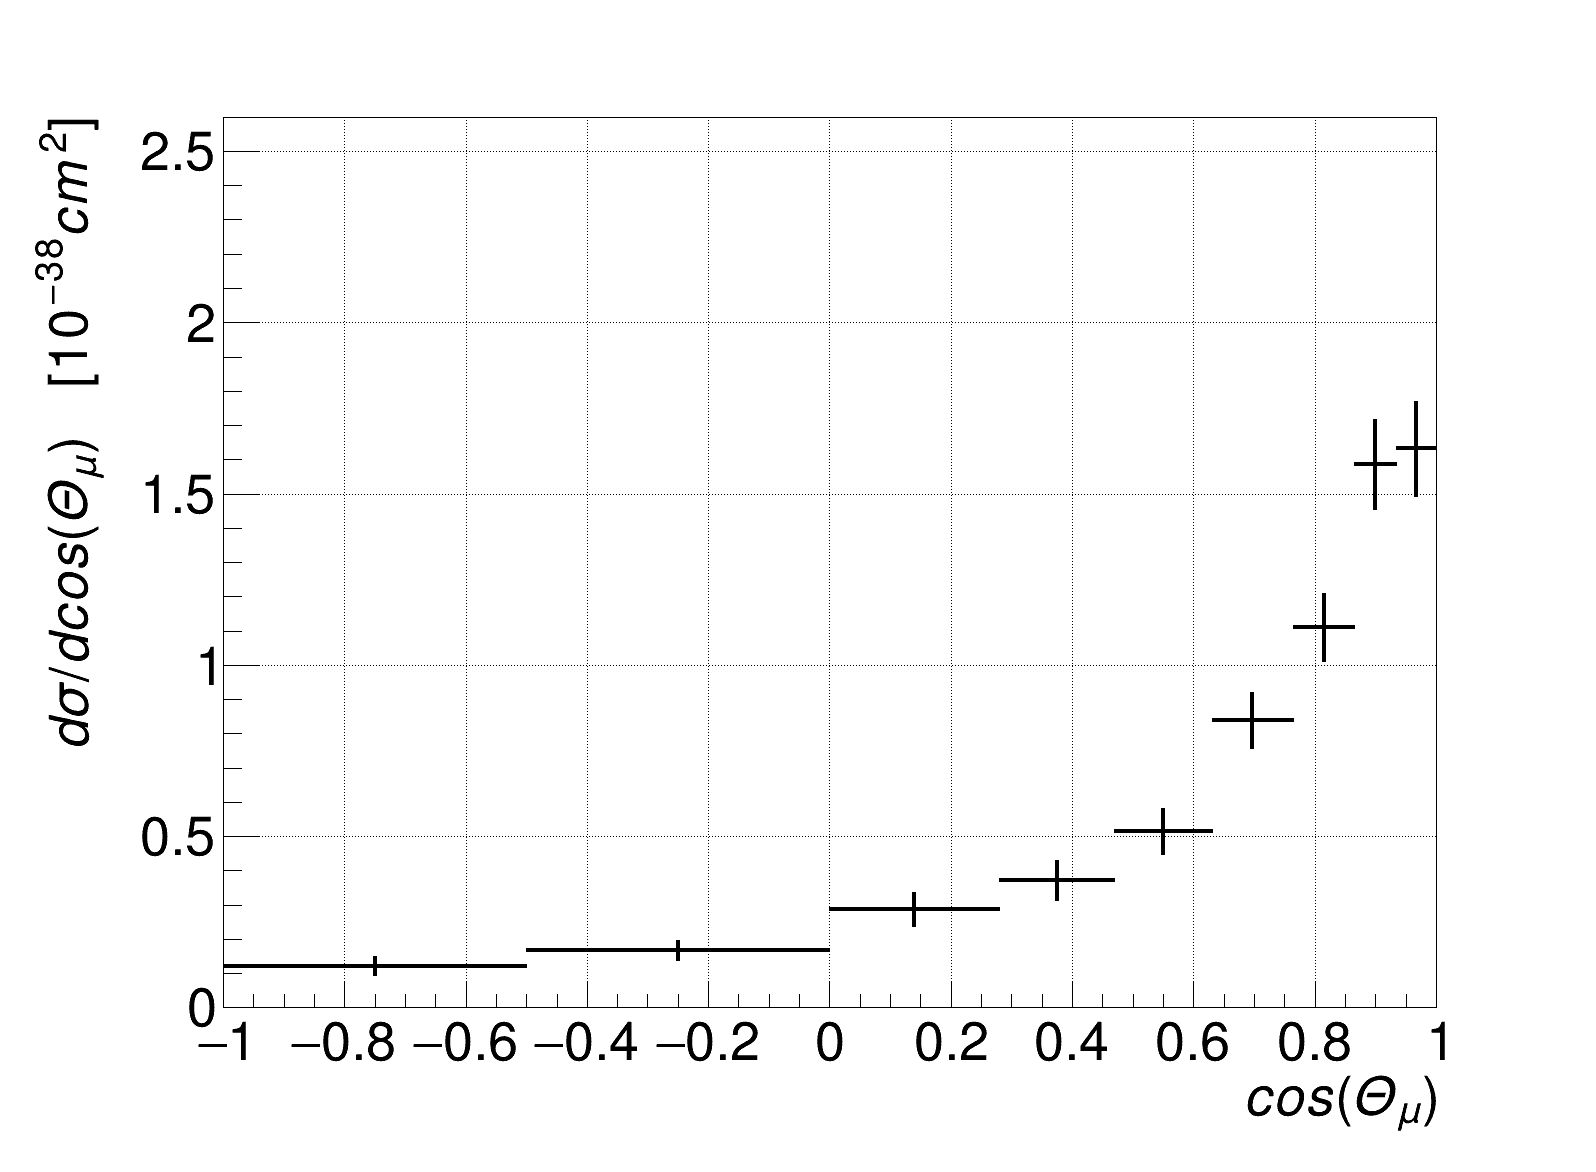

In [17]:
h_data = f_cv.Get('h_data')
h_ext = f_cv.Get('h_ext')
h_dirt = f_cv.Get('h_dirt')
h_overlay = f_cv.Get('h_overlay')
h_eff_true = f_cv.Get('h_eff_true')
h_eff_tilde = f_cv.Get('h_eff_tilde')
h_xsec_data = f_cv.Get('h_xsec_data_theta')
h_xsec_MC = f_cv.Get('h_xsec_MC_theta')
h_xsec_MC_noTune = f_cv.Get('h_xsec_MC_theta_noTune')


h_xsec_data.Draw()
c1.Draw()

In [18]:
path_all = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine_theta_mar18/'
f_all_genie = ROOT.TFile.Open(path_all+"xsec_genie_all_combine_theta.root", 'read')
h_covariance_all_genie = f_all_genie.Get('h_covariance')

path_genie_other = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_genie_other_mar18/'
f_genie_other = ROOT.TFile.Open(path_genie_other+"genie_other_theta_systematic.root", 'read')
h_covariance_other_genie = f_genie_other.Get('h_covariance')

path_detsys = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_detsys_all/'
f_detsys = ROOT.TFile.Open(path_detsys+"Detector_systematic_theta.root", 'read')
h_covariance_detsys = f_detsys.Get('h_covariance')

path_flux = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/Flux/output/'
f_flux = ROOT.TFile.Open(path_flux+"Flux_systematic_theta.root", 'read')
h_covariance_flux = f_flux.Get('h_covariance')

#path_crt = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/xsec_cross_check/'
#f_crt = ROOT.TFile.Open(path_crt+"xsec_crtsys_theta.root", 'read')
path_crt = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/xsec_crt_sys_2/'
f_crt = ROOT.TFile.Open(path_crt+"crt_covariance.root", 'read')
h_covariance_crt = f_crt.Get('h_covariance_theta')

path_dirt = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/xsec_wo_dirt/'
f_dirt = ROOT.TFile.Open(path_dirt+"dirt_covariance.root", 'read')
h_covariance_dirt = f_dirt.Get('h_covariance_theta')

path_G4 = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4_theta/'
f_G4 = ROOT.TFile.Open(path_G4+"G4_systematic_combine_theta.root", 'read')
h_covariance_G4 = f_G4.Get('h_covariance')

h_covariance_tot = h_covariance_all_genie.Clone()
h_covariance_tot.Add(h_covariance_other_genie)
h_covariance_tot.Add(h_covariance_detsys)
h_covariance_tot.Add(h_covariance_flux)
h_covariance_tot.Add(h_covariance_crt)
h_covariance_tot.Add(h_covariance_dirt)
h_covariance_tot.Add(h_covariance_G4)

h_cov_stat = h_covariance_tot.Clone()
for i in range(1,binnum):
    for j in range(1,binnum):
        if(i==j):
            h_cov_stat.SetBinContent(i,j,h_xsec_data.GetBinError(i)*h_xsec_data.GetBinError(j)*1e-76)
        else:
            h_cov_stat.SetBinContent(i,j,0.0)

            
h_cov_POT = h_covariance_tot.Clone()
for i in range(1,binnum):
    for j in range(1,binnum):
        #if(i==j):
        h_cov_POT.SetBinContent(i,j,h_xsec_data.GetBinContent(i)*h_xsec_data.GetBinContent(j)*0.02*0.02*1e-76)        
        #else:
        #    h_cov_POT.SetBinContent(i,j,0.0)

h_covariance_tot.Add(h_cov_stat)
h_covariance_tot.Add(h_cov_POT)

True

In [29]:
cov_matrix = np.zeros((binnum,binnum))
for i in range(1,binnum+1):
    for j in range(1,binnum+1):
        cov_matrix[i-1][j-1]=h_covariance_tot.GetBinContent(i,j)*1e76
xsec_diff = np.zeros((binnum))
for i in range(1,binnum+1):
    xsec_diff[i-1] = (h_xsec_data.GetBinContent(i) - h_xsec_MC.GetBinContent(i) )#*1e-38
cov_matrix_inv = np.linalg.inv(cov_matrix)

#print xsec_diffh_covariance_tot
#print np.transpose(xsec_diff)

chi2 = np.dot(xsec_diff,cov_matrix_inv)
chi2 = np.dot(chi2,xsec_diff)
print chi2
print chi2/binnum

1.5153637823677155
0.16837375359641282


In [28]:
cov_matrix = np.zeros((binnum,binnum))
for i in range(1,binnum+1):
    for j in range(1,binnum+1):
        cov_matrix[i-1][j-1]=h_covariance_tot.GetBinContent(i,j)*1e76
xsec_diff = np.zeros((binnum))
for i in range(1,binnum+1):
    xsec_diff[i-1] = (h_xsec_data.GetBinContent(i) - h_xsec_MC_noTune.GetBinContent(i) )#*1e-38
cov_matrix_inv = np.linalg.inv(cov_matrix)

#print xsec_diffh_covariance_tot
#print np.transpose(xsec_diff)

chi2 = np.dot(xsec_diff,cov_matrix_inv)
chi2 = np.dot(chi2,xsec_diff)
print chi2
print chi2/binnum

1.3942960266244264
0.15492178073604737


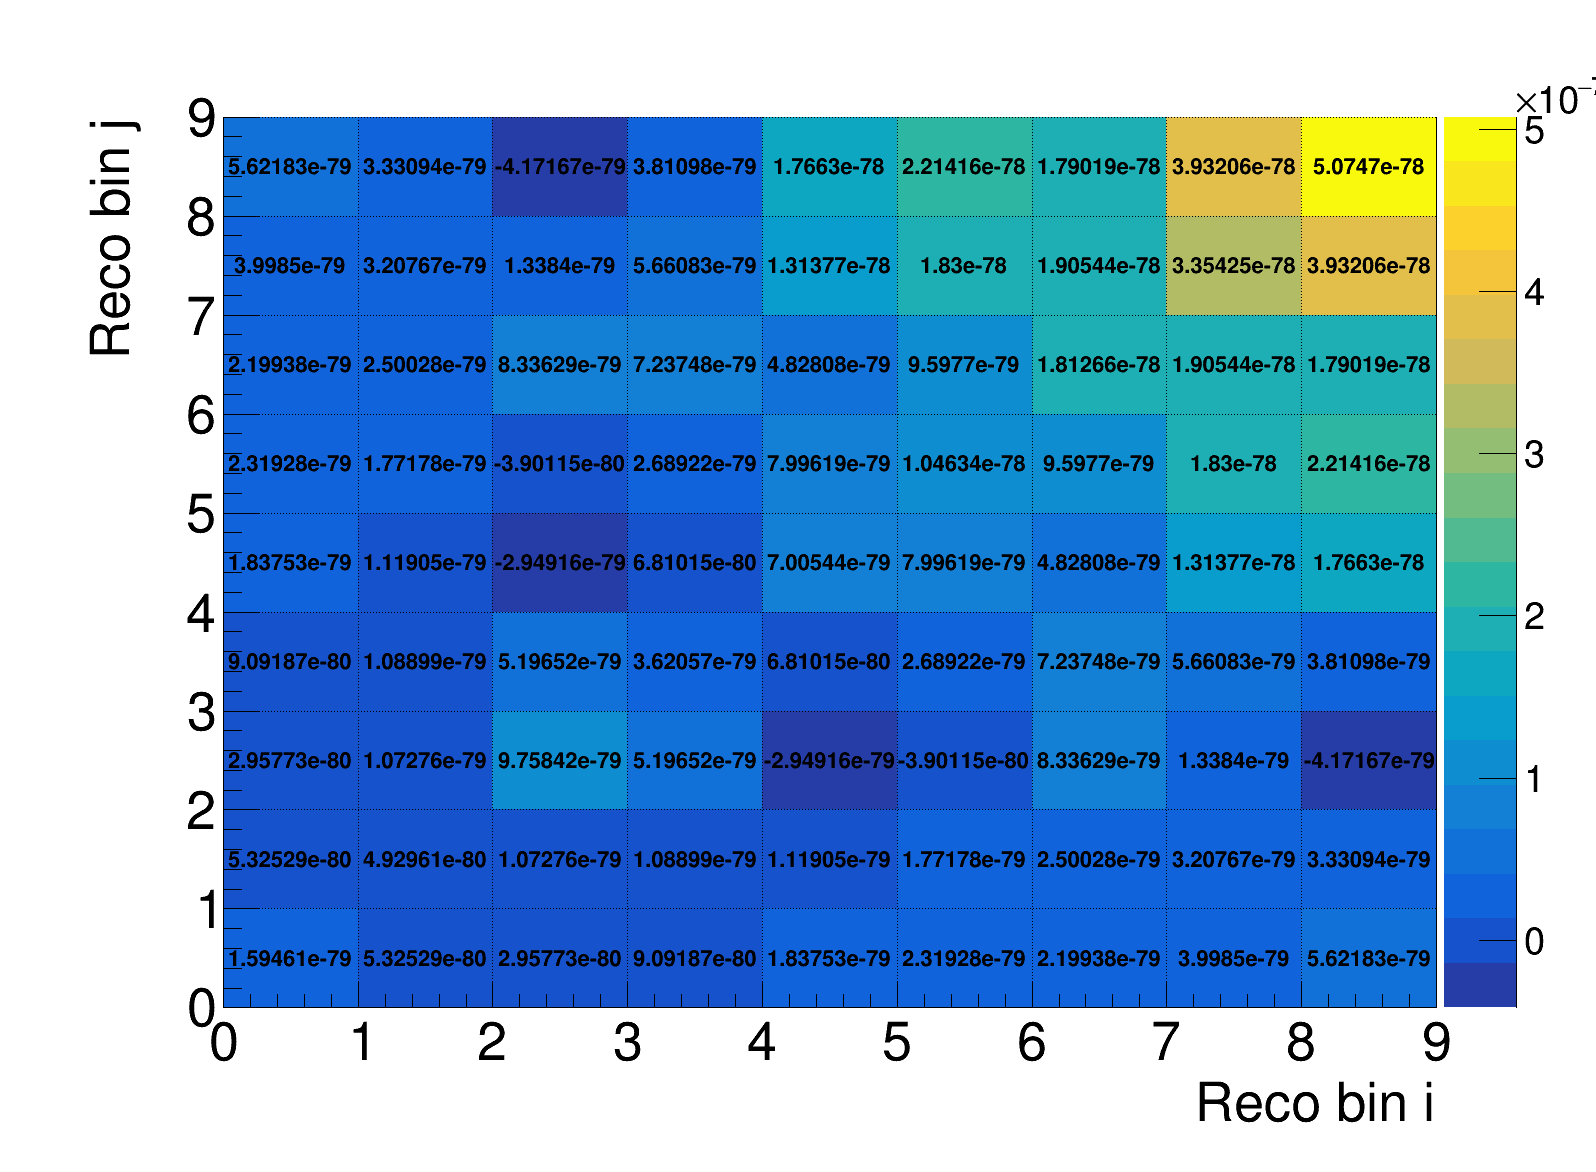

In [21]:
test = h_covariance_dirt.Clone()
test.Add(h_covariance_all_genie)
test.Add(h_covariance_other_genie)
test.Add(h_covariance_flux)
test.Add(h_covariance_crt)
test.Add(h_covariance_G4)
#test = f_flux.Get('h_frac_covariance')
test.Draw('colz')
test.Draw('Text same')
c1.Draw()

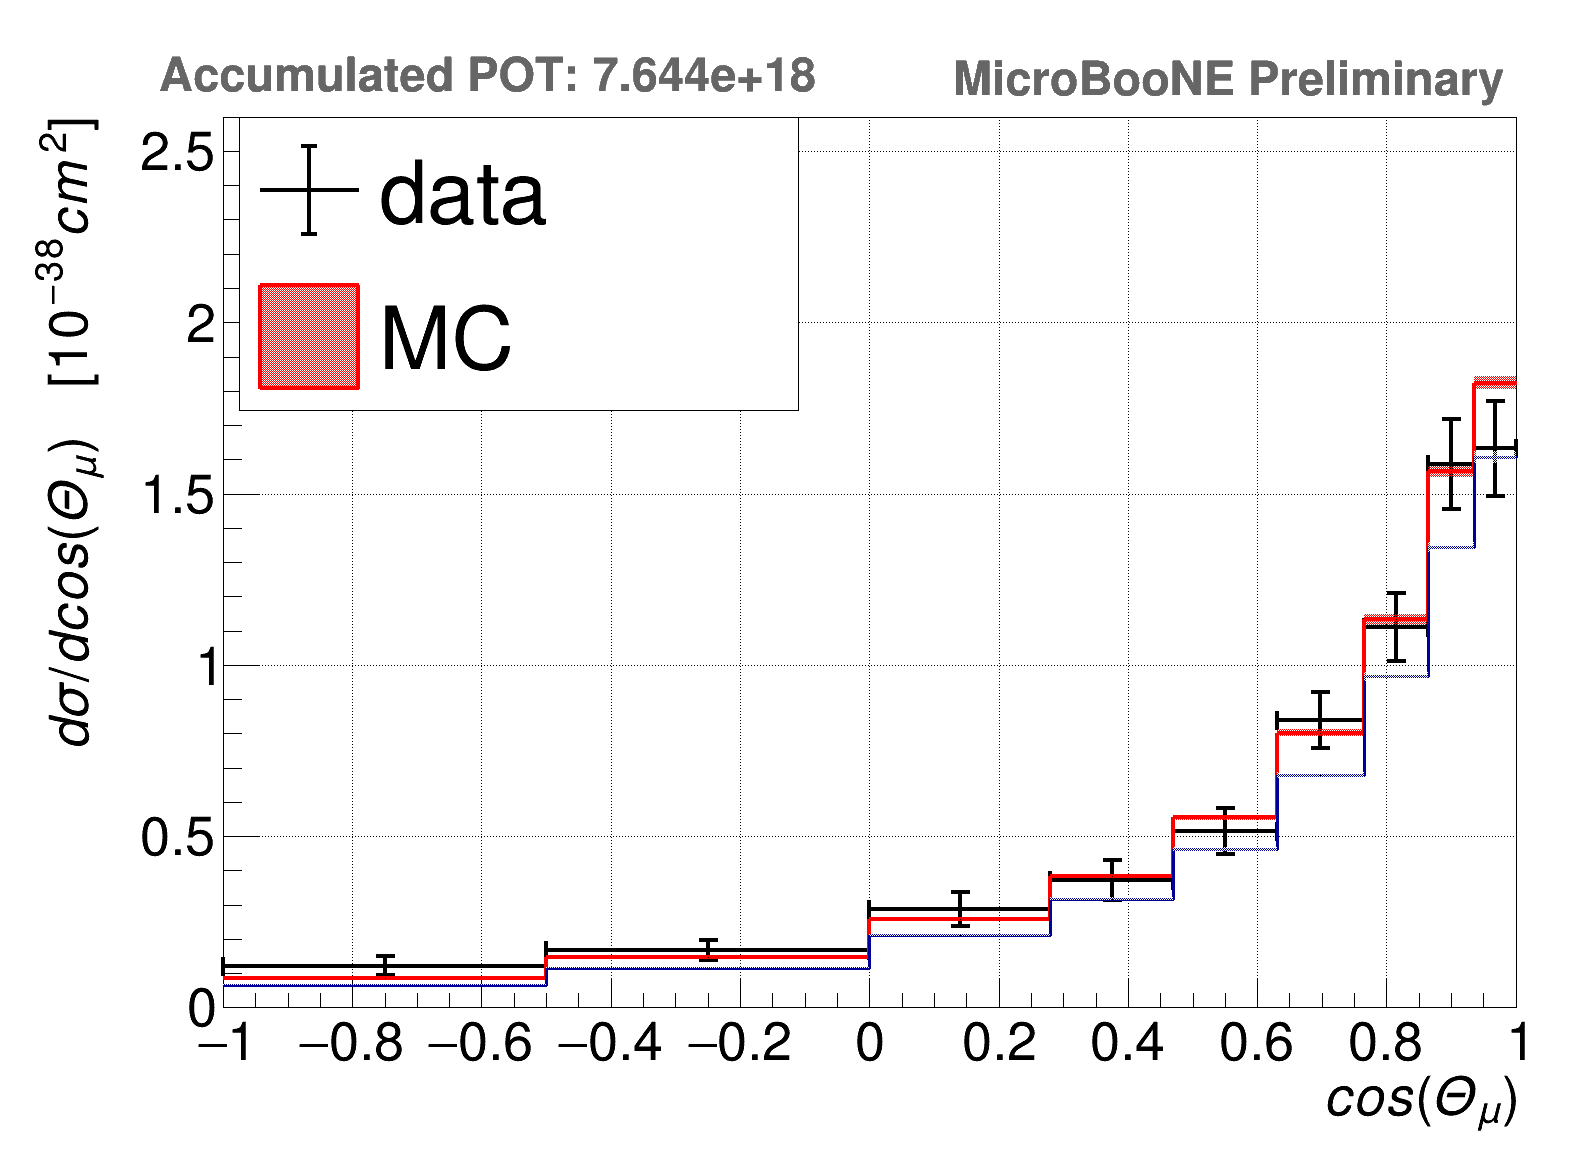

In [22]:
legend = ROOT.TLegend(0.15,0.65,0.5,0.9)
c1.SetRightMargin(0.05)

h_xsec_MC.SetLineColor(2)
legend.AddEntry(h_xsec_data,'data',"lep");
legend.AddEntry(h_xsec_MC,'MC',"f");
h_xsec_data.SetYTitle("d\sigma / dcos(\Theta_{\mu}) \t [10^{-38} cm^{2}]")
h_xsec_data.SetXTitle("cos(\Theta_{\mu})")
h_xsec_data.SetLineWidth(3)
h_xsec_data.SetMaximum(2.6)
h_xsec_data.SetMinimum(0)

h_xsec_data.GetYaxis().SetTitleSize(0.05)
h_xsec_data.GetYaxis().SetTitleOffset(0.0)
h_xsec_data.GetYaxis().SetLabelSize(0.05)
h_xsec_data.GetXaxis().SetTitleSize(0.05)
h_xsec_data.GetXaxis().SetLabelSize(0.05)
h_xsec_data.GetXaxis().SetTitleOffset(1)
h_xsec_data.SetLineColor(ROOT.kBlack)
h_xsec_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(9)
c1.SetRightMargin(0.05)

h_xsec_data.Draw('E1')
h_xsec_MC.SetFillColor(0)
h_xsec_MC.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_xsec_MC.DrawCopy('Hist same')
h_xsec_MC.SetFillColor(2)
h_xsec_MC.SetFillStyle(3001)
h_xsec_MC.Draw('E2 same')

h_xsec_MC_noTune.SetFillColor(0)
h_xsec_MC_noTune.SetLineWidth(3)
#h_overlay_sig.Draw('hist same')
h_xsec_MC_noTune.DrawCopy('Hist same')
h_xsec_MC_noTune.SetLineColor(ROOT.kBlue)
h_xsec_MC_noTune.SetFillStyle(3001)
h_xsec_MC_noTune.Draw('E2 same')

legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
#c1.SaveAs(globale.outputdir_png + "h_xsec_corr.png")
#c1.SaveAs(globale.outputdir_root + "h_xsec_corr.root")
#c1.SaveAs(globale.outputdir_pdf + "h_xsec_corr.pdf")

h_stat = h_xsec_data.Clone()

Bin  1 0.122231677175  stat. err:  0.0331067972584  fractional:  0.270852842927
Bin  2 0.167518571019  stat. err:  0.00513057406743  fractional:  0.030626897282
Bin  3 0.287445008755  stat. err:  0.00834038832981  fractional:  0.0290155962907
Bin  4 0.370980530977  stat. err:  0.0113629891174  fractional:  0.0306296103664
Bin  5 0.515427529812  stat. err:  0.0113245935394  fractional:  0.0219712624655
Bin  6 0.838753044605  stat. err:  0.014266899925  fractional:  0.0170096550072
Bin  7 1.11084723473  stat. err:  0.0171451669707  fractional:  0.0154343157499
Bin  8 1.58665347099  stat. err:  0.0242665657664  fractional:  0.0152941812501
Bin  9 1.63266026974  stat. err:  0.0518652791511  fractional:  0.0317673432204
Bin  9
stat_err:  1.92873487629e-78
pot_err:  1.06623182255e-79
All_Genie:  1.14286967088e-79
genie_other_err:  5.6259614035e-80
G4_err:  9.23649352814e-81
detsys_err:  6.28152597873e-79
flux_err:  4.61192816928e-78
crt_err:  1.39929999053e-80


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_result/png/h_xsec_sys_all_theta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_result/root/h_xsec_sys_all_theta.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_result/pdf/h_xsec_sys_all_theta.pdf has been created


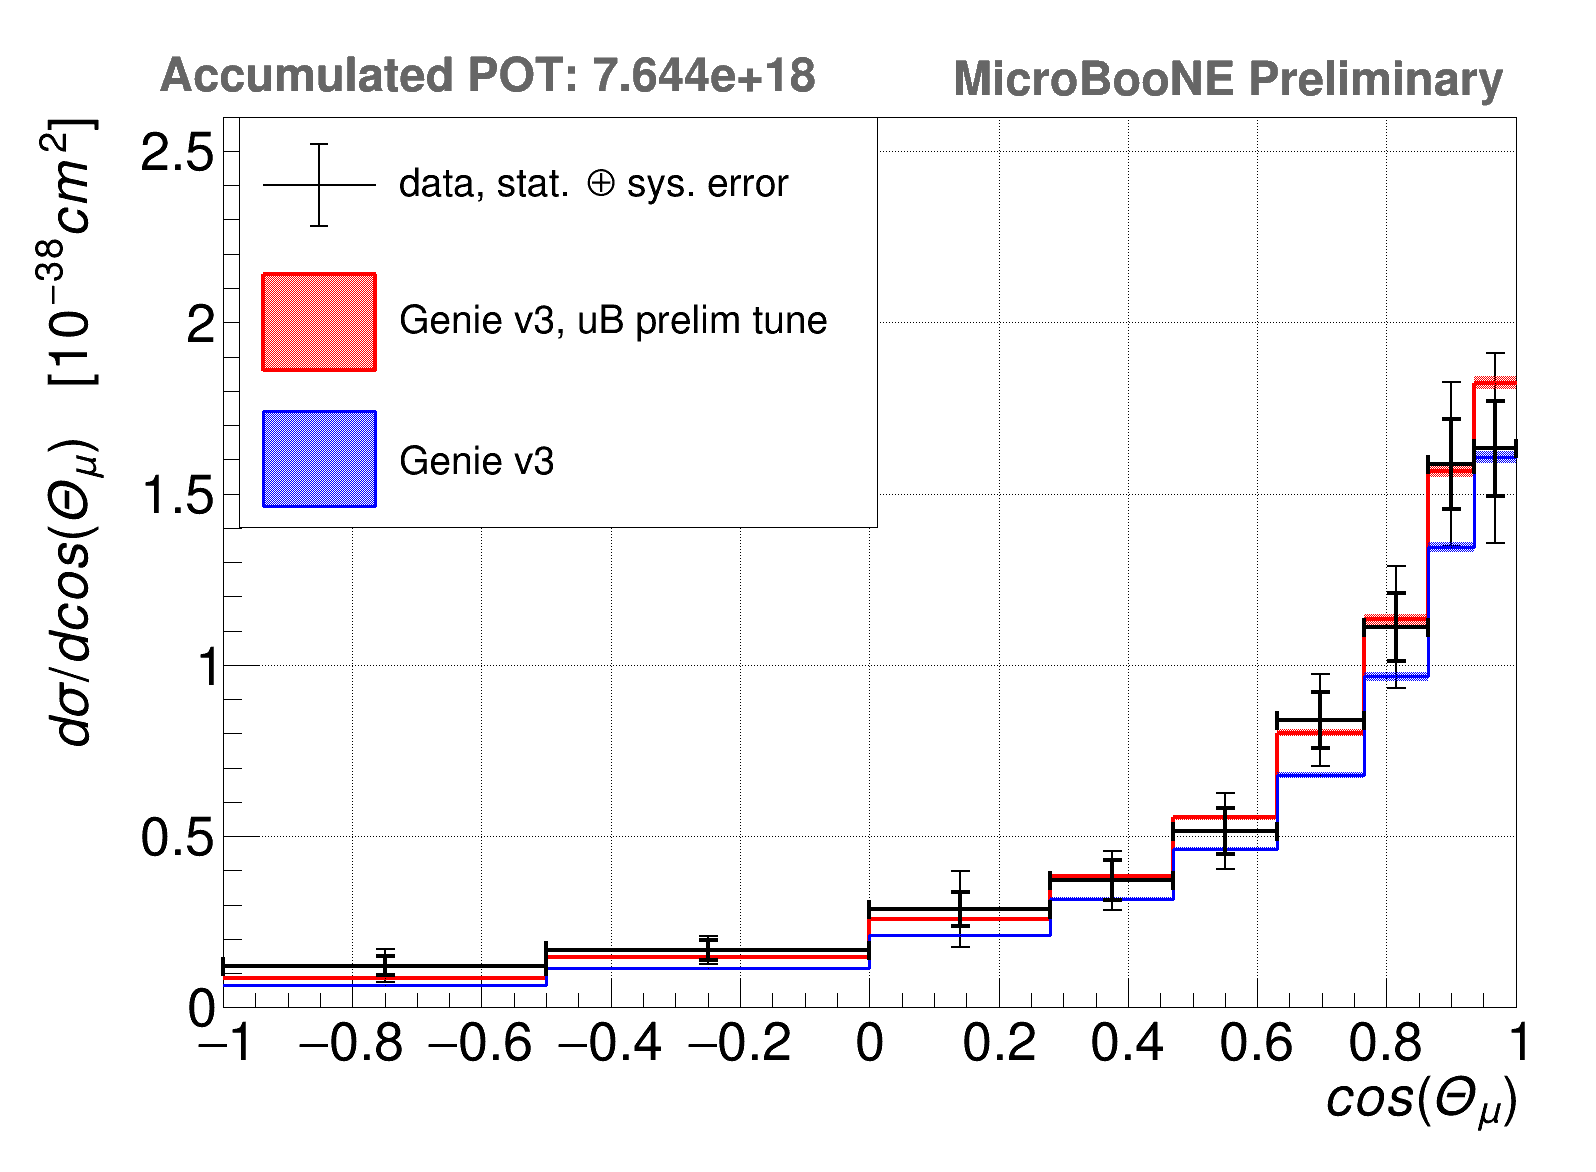

In [23]:
#all systematics
legend = ROOT.TLegend(0.15,0.55,0.55,0.9)
h_xsec_MC.SetLineColor(2)
legend.AddEntry(h_xsec_data,'data, stat. #oplus sys. error',"lep");
legend.AddEntry(h_xsec_MC,'Genie v3, uB prelim tune',"f");
legend.AddEntry(h_xsec_MC_noTune,'Genie v3',"f");

c1.SetRightMargin(0.05)
ROOT.gStyle.SetEndErrorSize(9)

stat_err_arr = np.zeros((binnum))
pot_err_arr = np.zeros((binnum))
genie_all_err_arr = np.zeros((binnum))
genie_other_arr = np.zeros((binnum))
det_err_arr = np.zeros((binnum))
flux_err_arr = np.zeros((binnum))
crt_err_arr = np.zeros((binnum))
G4_err_arr = np.zeros((binnum))
dirt_err_arr = np.zeros((binnum))
tot_err_arr = np.zeros((binnum))


for i in range(1,binnum+1):
    stat_err = h_stat.GetBinError(i)
    stat_err = stat_err*stat_err
    pot_err = h_stat.GetBinContent(i)*0.02
    pot_err = pot_err*pot_err
    #crt_err = h_stat.GetBinContent(i)*0.01648
    #crt_err = crt_err*crt_err
    genie_all_err = h_covariance_all_genie.GetBinContent(i,i)*1e76
    genie_other_err = h_covariance_other_genie.GetBinContent(i,i)*1e76
    detsys_err = h_covariance_detsys.GetBinContent(i,i)*1e76
    flux_err = h_covariance_flux.GetBinContent(i,i)*1e76
    crt_err = h_covariance_crt.GetBinContent(i,i)*1e76
    G4_err = h_covariance_G4.GetBinContent(i,i)*1e76
    dirt_err = h_covariance_dirt.GetBinContent(i,i)*1e76
    
    stat_err_arr[i-1] = math.sqrt(stat_err)
    pot_err_arr[i-1] = math.sqrt(pot_err)
    genie_all_err_arr[i-1] = math.sqrt(genie_all_err)
    genie_other_arr[i-1] = math.sqrt(genie_other_err)
    det_err_arr[i-1] = math.sqrt(detsys_err)
    flux_err_arr[i-1] = math.sqrt(flux_err)
    crt_err_arr[i-1] = math.sqrt(crt_err)
    G4_err_arr[i-1] = math.sqrt(G4_err)
    dirt_err_arr[i-1] = math.sqrt(dirt_err)
    
    #print stat_err,genie_all_err,genie_other_err,detsys_err,flux_err,G4_err
    #print 'Bin ',i, h_xsec_data.GetBinContent(i)
    
    print 'Bin ',i, h_xsec_data.GetBinContent(i), ' stat. err: ',math.sqrt(dirt_err),' fractional: ',math.sqrt(dirt_err)/h_xsec_data.GetBinContent(i)
    
    #print 'stat_err: ' ,math.sqrt(stat_err),math.sqrt(stat_err)/h_xsec_data.GetBinContent(i)
    #print 'genie_all_err: ',genie_all_err/1e76 ,math.sqrt(genie_all_err)
    #print 'stat_err: ',stat_err/1e76 ,math.sqrt(stat_err)/h_xsec_data.GetBinContent(i)
    #print 'pot_err: ',pot_err/1e76 ,math.sqrt(pot_err)/h_xsec_data.GetBinContent(i)
    #print 'All_Genie: ',genie_all_err/1e76 ,math.sqrt(genie_all_err)/h_xsec_data.GetBinContent(i)
    #print 'genie_other_err: ',genie_other_err/1e76 ,math.sqrt(genie_other_err)/h_xsec_data.GetBinContent(i)
    #print 'G4_err: ',G4_err/1e76 ,math.sqrt(G4_err)/h_xsec_data.GetBinContent(i)
    #print 'detsys_err: ',detsys_err/1e76 ,math.sqrt(detsys_err)/h_xsec_data.GetBinContent(i)
    #print 'flux_err: ',flux_err/1e76 ,math.sqrt(flux_err)/h_xsec_data.GetBinContent(i)
    #print 'crt_err: ',crt_err/1e76 ,math.sqrt(crt_err)/h_xsec_data.GetBinContent(i)
    h_xsec_data.SetBinError(i,math.sqrt(stat_err+pot_err+crt_err+genie_all_err+genie_other_err+detsys_err+flux_err+G4_err+dirt_err))
    tot_err_arr[i-1] = h_xsec_data.GetBinError(i)
        
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/stat_err_arr_theta',stat_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/pot_err_arr_theta',pot_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/genie_all_err_arr_theta',genie_all_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/genie_other_arr_theta',genie_other_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/det_err_arr_theta',det_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/flux_err_arr_theta',flux_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/crt_err_arr_theta',crt_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/G4_err_arr_theta',G4_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/tot_err_arr_theta',tot_err_arr)


h_xsec_data.SetLineWidth(2)
h_xsec_data.Draw('E1')

h_xsec_MC.SetFillColor(0)
h_xsec_MC.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_xsec_MC.DrawCopy('Hist same')
h_xsec_MC.SetFillColor(2)
h_xsec_MC.SetFillStyle(3001)
h_xsec_MC.Draw('E2 same')

#h_xsec_MC_noTune.SetLineColor(ROOT.kBlue)
#h_xsec_MC_noTune.SetLineWidth(3)
#h_xsec_MC_noTune.Draw('same hist')

h_xsec_MC_noTune.SetFillColor(0)
h_xsec_MC_noTune.SetLineWidth(3)
#h_overlay_sig.Draw('hist same')
h_xsec_MC_noTune.DrawCopy('Hist same')
h_xsec_MC_noTune.SetFillColor(ROOT.kBlue)
h_xsec_MC_noTune.SetFillStyle(3001)
h_xsec_MC_noTune.Draw('E2 same')

h_stat.Draw('E1 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_sys_all_theta.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_sys_all_theta.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_sys_all_theta.pdf")

print 'Bin ',i
print 'stat_err: ',stat_err/1e76
print 'pot_err: ',pot_err/1e76
print 'All_Genie: ',genie_all_err/1e76
print 'genie_other_err: ',genie_other_err/1e76
print 'G4_err: ',G4_err/1e76
print 'detsys_err: ',detsys_err/1e76
print 'flux_err: ',flux_err/1e76
print 'crt_err: ',crt_err/1e76


In [24]:
res = np.zeros((9))
chi2_nom =h_xsec_data.Chi2Test(h_xsec_MC,"P CHI2",res)
chi2_nom =h_xsec_data.Chi2Test(h_xsec_MC_noTune,"P CHI2",res)
#zdfzzdf

Chi2 = 1.615717, Prob = 0.990616, NDF = 8, igood = 1
Chi2 = 2.542168, Prob = 0.959736, NDF = 8, igood = 1


Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.



Bin  1
stat_err:  7.65732759693e-80
pot_err:  5.97623316196e-82
All_Genie:  1.05559603486e-80
genie_other_err:  4.41011176256e-82
G4_err:  1.87212872247e-81
detsys_err:  4.63381524021e-81
flux_err:  3.46182965642e-80
crt_err:  2.36753153701e-81
dirt_err:  1.09606002471e-79
Bin  2
stat_err:  8.76644981465e-80
pot_err:  1.12249886545e-81
All_Genie:  4.50182366278e-81
genie_other_err:  5.20197128529e-81
G4_err:  5.47410498859e-82
detsys_err:  2.11397992948e-80
flux_err:  3.40323533123e-80
crt_err:  2.38023062937e-81
dirt_err:  2.63227902614e-81
Bin  3
stat_err:  2.34764392852e-79
pot_err:  3.30498532232e-81
All_Genie:  1.16098445706e-80
genie_other_err:  9.68878608591e-81
G4_err:  3.82563302688e-81
detsys_err:  3.52981910852e-80
flux_err:  9.36715043295e-79
crt_err:  7.04602107314e-81
dirt_err:  6.95620774921e-81
Bin  4
stat_err:  3.4591287017e-79
pot_err:  5.50506217457e-81
All_Genie:  1.62456125304e-80
genie_other_err:  1.11964269757e-80
G4_err:  1.49558648124e-81
detsys_err:  2.6066885

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_result/png/h_xsec_sys_only_theta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_result/root/h_xsec_sys_only_theta.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_result/pdf/h_xsec_sys_only_theta.pdf has been created


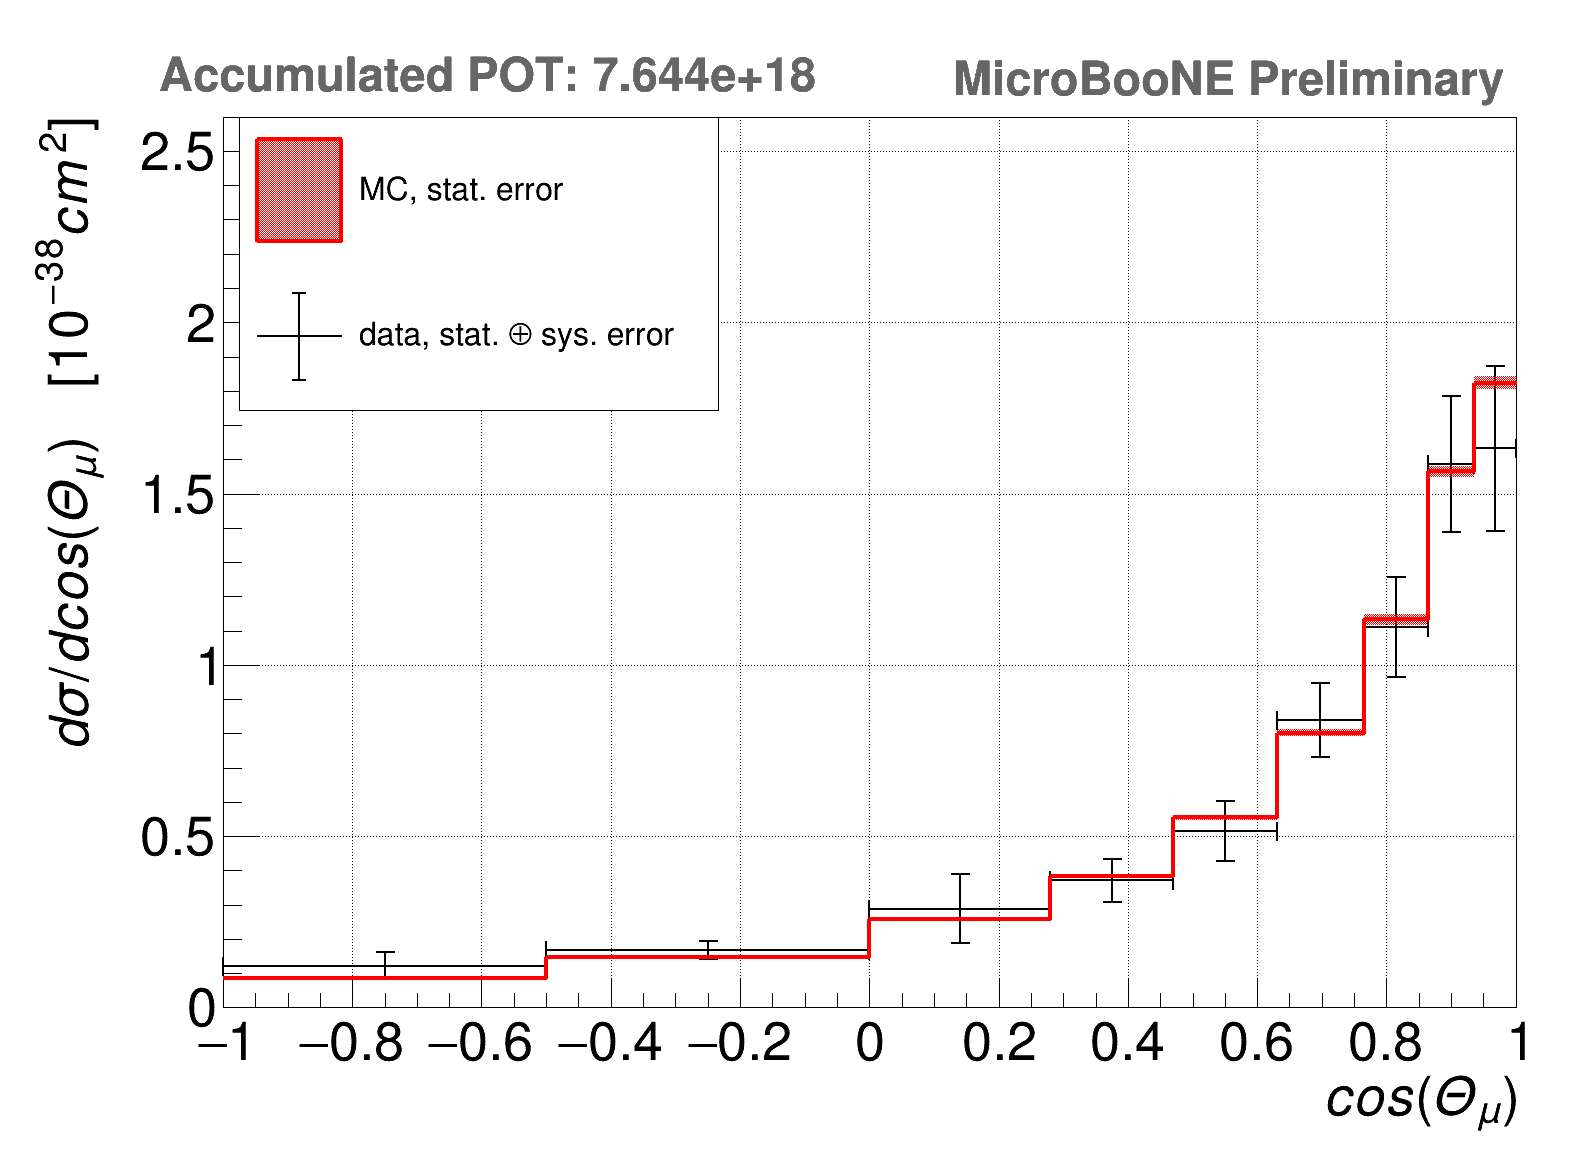

In [25]:
#all systematics
legend = ROOT.TLegend(0.15,0.65,0.45,0.9)
h_xsec_MC.SetLineColor(2)
legend.AddEntry(h_xsec_MC,'MC, stat. error',"f");
legend.AddEntry(h_xsec_data,'data, stat. #oplus sys. error',"lep");
c1.SetRightMargin(0.05)
ROOT.gStyle.SetEndErrorSize(9)
for i in range(1,binnum+1):   
    stat_err = h_stat.GetBinError(i)
    stat_err = stat_err*stat_err
    pot_err = h_stat.GetBinContent(i)*0.02
    pot_err = pot_err*pot_err
    #crt_err = h_stat.GetBinContent(i)*0.01648
    #crt_err = crt_err*crt_err
    genie_all_err = h_covariance_all_genie.GetBinContent(i,i)*1e76
    genie_other_err = h_covariance_other_genie.GetBinContent(i,i)*1e76
    detsys_err = h_covariance_detsys.GetBinContent(i,i)*1e76
    flux_err = h_covariance_flux.GetBinContent(i,i)*1e76
    crt_err = h_covariance_crt.GetBinContent(i,i)*1e76
    G4_err = h_covariance_G4.GetBinContent(i,i)*1e76
    dirt_err = h_covariance_dirt.GetBinContent(i,i)*1e76
    #print stat_err,genie_all_err,genie_other_err,detsys_err,flux_err,G4_err
    print 'Bin ',i
    print 'stat_err: ',stat_err/1e76
    print 'pot_err: ',pot_err/1e76
    print 'All_Genie: ',genie_all_err/1e76
    print 'genie_other_err: ',genie_other_err/1e76
    print 'G4_err: ',G4_err/1e76
    print 'detsys_err: ',detsys_err/1e76
    print 'flux_err: ',flux_err/1e76
    print 'crt_err: ',crt_err/1e76
    print 'dirt_err: ',dirt_err/1e76
    
    h_xsec_data.SetBinError(i,math.sqrt(0*stat_err+pot_err+crt_err+genie_all_err+genie_other_err+detsys_err+flux_err+G4_err+dirt_err))

h_xsec_data.SetLineWidth(2)
h_xsec_data.Draw('E1')
h_xsec_MC.SetFillColor(0)
h_xsec_MC.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_xsec_MC.DrawCopy('Hist same')
h_xsec_MC.SetFillColor(2)
h_xsec_MC.SetFillStyle(3001)
h_xsec_MC.Draw('E2 same')
#h_stat.Draw('E1 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_sys_only_theta.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_sys_only_theta.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_sys_only_theta.pdf")


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_result/png/h_xsec_compare_theta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_result/root/h_xsec_compare_theta.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_result/pdf/h_xsec_compare_theta.pdf has been created


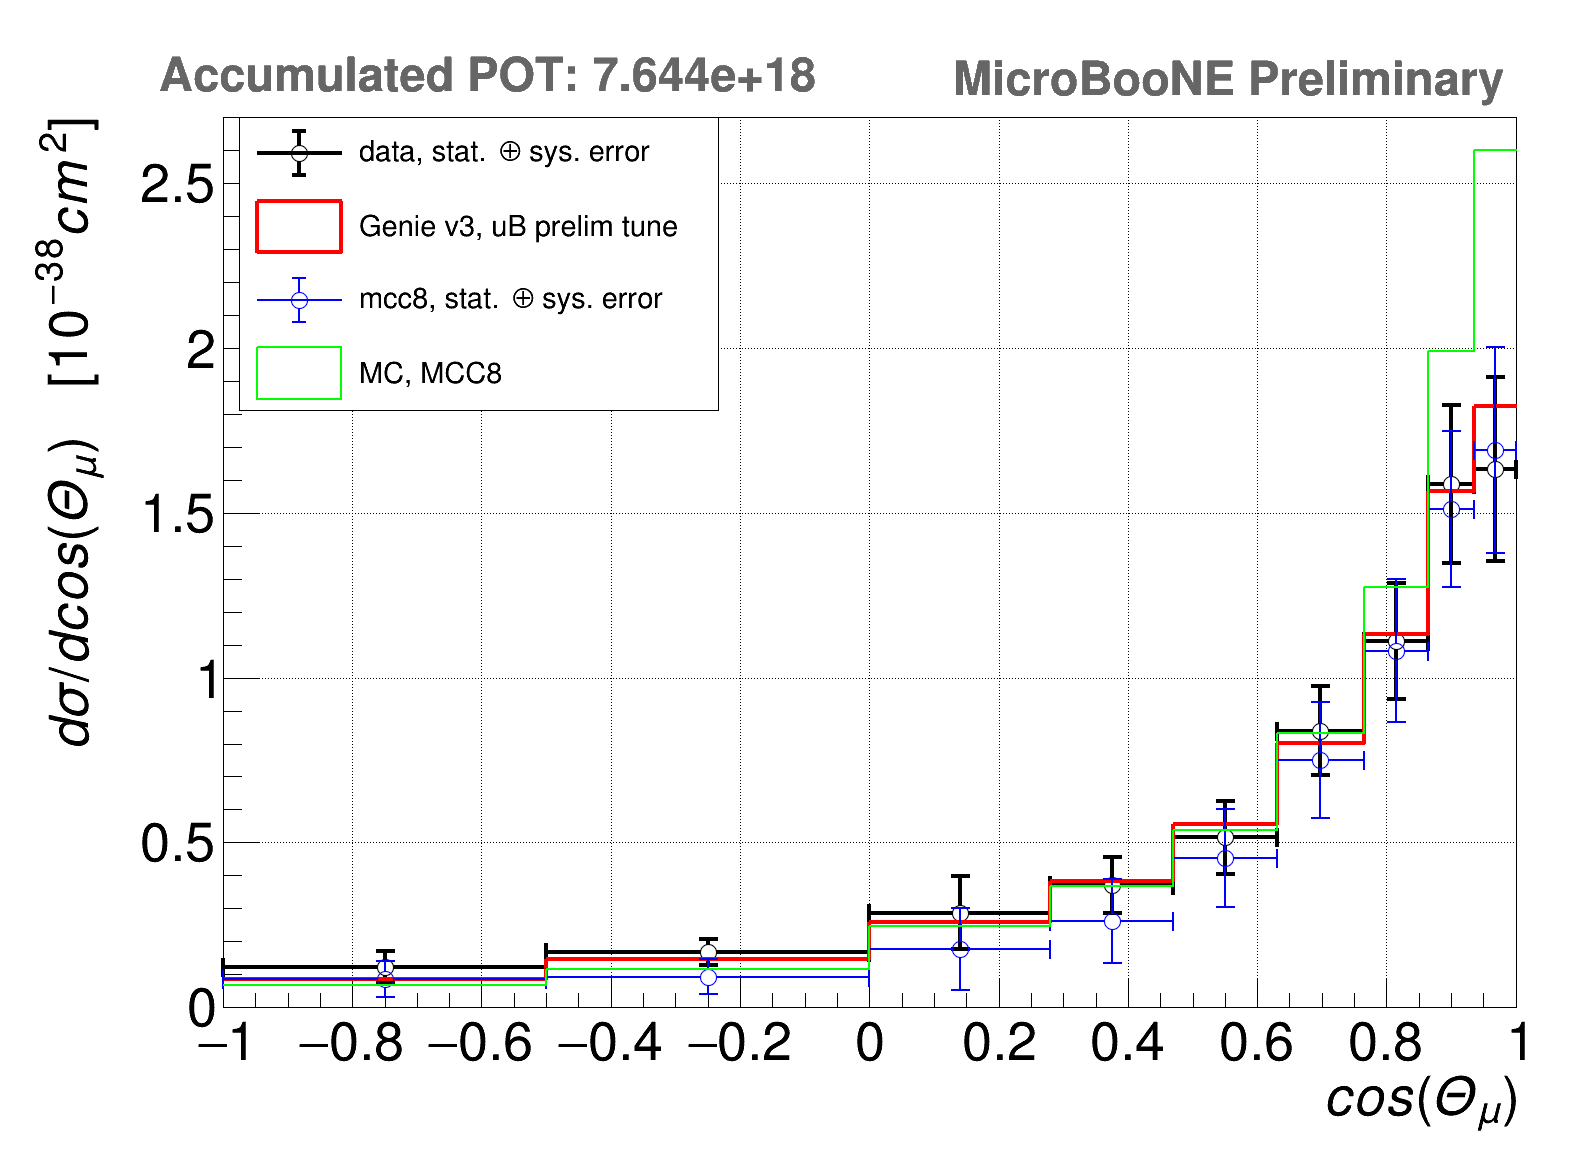

In [26]:
#all systematics
legend = ROOT.TLegend(0.15,0.65,0.45,0.9)
h_xsec_MC.SetLineColor(2)
legend.AddEntry(h_xsec_data,'data, stat. #oplus sys. error',"lep");
legend.AddEntry(h_xsec_MC,'Genie v3, uB prelim tune',"f");
c1.SetRightMargin(0.05)
ROOT.gStyle.SetEndErrorSize(9)
mcc8_y = [0.08737, 0.09342, 0.17695, 0.26192, 0.4522, 0.75058, 1.08054, 1.51128, 1.68893]
mcc8_e1 = [0.14177, 0.1466, 0.30186, 0.38825, 0.60128, 0.9264, 1.29728, 1.74817, 2.00041]
h_mcc8 = h_stat.Clone()
legend.AddEntry(h_mcc8,'mcc8, stat. #oplus sys. error',"lep");
mcc8_genie = [0.06806, 0.11625, 0.24561, 0.3686, 0.53874, 0.83209, 1.27483, 1.9905, 2.63044]
h_mcc8_genie = h_stat.Clone()
legend.AddEntry(h_mcc8_genie,'MC, MCC8',"f");

for i in range(1,binnum+1):   
    h_mcc8.SetBinContent(i,mcc8_y[i-1])
    h_mcc8.SetBinError(i,mcc8_e1[i-1] - mcc8_y[i-1])
    h_mcc8_genie.SetBinContent(i,mcc8_genie[i-1])
    stat_err = h_stat.GetBinError(i)
    stat_err = stat_err*stat_err
    pot_err = h_stat.GetBinContent(i)*0.02
    pot_err = pot_err*pot_err
    genie_all_err = h_covariance_all_genie.GetBinContent(i,i)*1e76
    genie_other_err = h_covariance_other_genie.GetBinContent(i,i)*1e76
    detsys_err = h_covariance_detsys.GetBinContent(i,i)*1e76
    flux_err = h_covariance_flux.GetBinContent(i,i)*1e76
    crt_err = h_covariance_crt.GetBinContent(i,i)*1e76
    G4_err = h_covariance_G4.GetBinContent(i,i)*1e76
    dirt_err = h_covariance_dirt.GetBinContent(i,i)*1e76
    
    h_xsec_data.SetBinError(i,math.sqrt(stat_err+pot_err+crt_err+genie_all_err+genie_other_err+detsys_err+flux_err+G4_err+dirt_err))
h_xsec_data.SetMaximum(2.7)
h_xsec_data.SetLineWidth(4)
h_xsec_data.SetMarkerStyle(4)
h_xsec_data.SetMarkerSize(2)
h_xsec_data.Draw('E1')

h_xsec_MC.SetFillColor(0)
h_xsec_MC.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_xsec_MC.Draw('Hist same')
#h_xsec_MC.SetFillColor(2)
#h_xsec_MC.SetFillStyle(3001)
#h_xsec_MC.Draw('E2 same')
#h_stat.Draw('E1 same')
h_mcc8.SetLineColor(ROOT.kBlue)
h_mcc8.SetMarkerColor(ROOT.kBlue)
h_mcc8.SetLineWidth(2)
h_mcc8.SetMarkerStyle(4)
h_mcc8.SetMarkerSize(2)
h_mcc8.Draw('E1 same')

h_mcc8_genie.SetLineColor(ROOT.kGreen)
h_mcc8_genie.SetLineWidth(2)
h_mcc8_genie.Draw('Hist same')


legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_compare_theta.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_compare_theta.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_compare_theta.pdf")


In [27]:
'''#all systematics
legend = ROOT.TLegend(0.15,0.65,0.45,0.9)
h_xsec_MC.SetLineColor(2)
legend.AddEntry(h_xsec_MC,'MC, stat. error',"f");
legend.AddEntry(h_xsec_data,'data, stat. #oplus sys. error',"lep");
c1.SetRightMargin(0.05)
bin_n = 9
h_xsec_data_2 = h_xsec_data.Clone()
h_xsec_data_2.Rebin(bin_n)
h_xsec_data_2.Scale(1.0/bin_n)
h_xsec_data_2.SetMaximum(1)
h_xsec_data_2.Draw('E1')
h_xsec_MC_2 = h_xsec_MC.Clone()
h_xsec_MC_2.SetFillColor(0)
h_xsec_MC_2.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_xsec_MC_2.Rebin(bin_n)
h_xsec_MC_2.Scale(1.0/bin_n)
h_xsec_MC_2.DrawCopy('Hist same')
h_xsec_MC_2.SetFillColor(2)
h_xsec_MC_2.SetFillStyle(3001)
h_xsec_MC_2.Draw('E2 same')
h_stat_2 = h_stat.Clone()
h_stat_2.Rebin(bin_n)
h_stat_2.Scale(1.0/bin_n)
h_stat_2.Draw('E1 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_corr.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_corr.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_corr.pdf")
'''

'#all systematics\nlegend = ROOT.TLegend(0.15,0.65,0.45,0.9)\nh_xsec_MC.SetLineColor(2)\nlegend.AddEntry(h_xsec_MC,\'MC, stat. error\',"f");\nlegend.AddEntry(h_xsec_data,\'data, stat. #oplus sys. error\',"lep");\nc1.SetRightMargin(0.05)\nbin_n = 9\nh_xsec_data_2 = h_xsec_data.Clone()\nh_xsec_data_2.Rebin(bin_n)\nh_xsec_data_2.Scale(1.0/bin_n)\nh_xsec_data_2.SetMaximum(1)\nh_xsec_data_2.Draw(\'E1\')\nh_xsec_MC_2 = h_xsec_MC.Clone()\nh_xsec_MC_2.SetFillColor(0)\nh_xsec_MC_2.SetLineWidth(4)\n#h_overlay_sig.Draw(\'hist same\')\nh_xsec_MC_2.Rebin(bin_n)\nh_xsec_MC_2.Scale(1.0/bin_n)\nh_xsec_MC_2.DrawCopy(\'Hist same\')\nh_xsec_MC_2.SetFillColor(2)\nh_xsec_MC_2.SetFillStyle(3001)\nh_xsec_MC_2.Draw(\'E2 same\')\nh_stat_2 = h_stat.Clone()\nh_stat_2.Rebin(bin_n)\nh_stat_2.Scale(1.0/bin_n)\nh_stat_2.Draw(\'E1 same\')\nlegend.Draw()\nprelim, pot_tex = draw_adding()\nprelim.Draw()\npot_tex.Draw()\nc1.Draw()\nc1.SaveAs(globale.outputdir_png + "h_xsec_corr.png")\nc1.SaveAs(globale.outputdir_root + "